# Full Food101

We're going to learn about two methods to significantly improve the speed of our model training:
1. Prefetching
2. Mixed precision training

In [1]:
# Check TensorFlow version (should be 2.4.0+)
import tensorflow as tf
print(tf.__version__)

2.13.0


In [2]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2023-10-18 14:52:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-18 14:52:40 (73.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [5]:
# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is the dataset we're after available?

True


In [6]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteCBG2D3/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteCBG2D3/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [7]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

Because we used the `as_supervised=True` parameter in our `tfds.load()` method above, data samples come in the tuple format structure `(data, label)` or in our case `(image_tensor, label)`.

In [10]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Let's loop through our single training sample and get some info from the `image_tensor` and `label`.

In [11]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 90
  Class name (str form): spaghetti_bolognese
        


Because we set the `shuffle_files=True` parameter in our `tfds.load()` method above, running the cell above a few times will give a different result each time.

Checking these you might notice some of the images have different shapes, for example `(512, 342, 3)` and `(512, 512, 3)` (height, width, color_channels).

In [12]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 12,  13,   7],
        [ 12,  13,   7],
        [ 13,  14,   8],
        ...,
        [ 21,  11,   0],
        [ 21,  11,   0],
        [ 21,  11,   0]],

       [[ 12,  13,   7],
        [ 11,  12,   6],
        [ 11,  12,   6],
        ...,
        [ 21,  11,   0],
        [ 21,  11,   0],
        [ 21,  11,   0]],

       [[  7,   8,   2],
        [  7,   8,   2],
        [  7,   8,   2],
        ...,
        [ 22,  12,   2],
        [ 21,  11,   1],
        [ 20,  10,   0]],

       ...,

       [[188, 191, 184],
        [188, 191, 184],
        [188, 191, 184],
        ...,
        [243, 248, 244],
        [243, 248, 244],
        [242, 247, 243]],

       [[187, 190, 183],
        [189, 192, 185],
        [190, 193, 186],
        ...,
        [241, 245, 244],
        [241, 245, 244],
        [241, 245, 244]],

       [[186, 189, 182],
        [189, 192, 185],
        [191, 194, 187],
        ...,
        [238, 242, 24

In [13]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

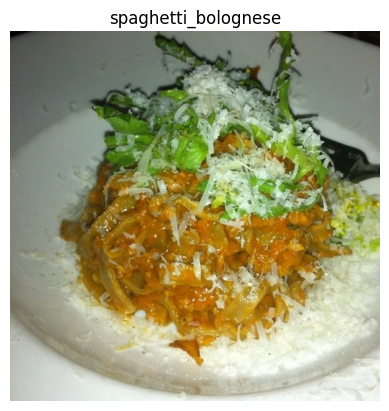

In [14]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

## Create preprocessing functions for our data
* In `float32` data type
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. `(224, 224, 3)`)
* Scaled (values between 0 & 1), also called normalized

To take care of these, we'll create a `preprocess_img()` function which:

* Resizes an input image tensor to a specified size using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize)
* Converts an input image tensor's current datatype to `tf.float32` using [`tf.cast()`](https://www.tensorflow.org/api_docs/python/tf/cast)

In [15]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=300):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [16]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[12 13  7]
  [12 13  7]
  [13 14  8]
  ...
  [21 11  0]
  [21 11  0]
  [21 11  0]]

 [[12 13  7]
  [11 12  6]
  [11 12  6]
  ...
  [21 11  0]
  [21 11  0]
  [21 11  0]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[11.875155   12.875155    6.8751554 ]
  [12.293333   13.293333    7.293333  ]
  [11.526667   12.526667    7.293333  ]
  ...
  [20.624222   10.624221    0.5417749 ]
  [20.9612     10.961202    0.        ]
  [21.         11.          0.        ]]

 [[ 6.7000003   7.7000003   1.8800001 ]
  [ 6.6472      7.6472      1.8236002 ]
  [ 5.0993333   6.0993333   0.94000006]
  ...
  [23.119999   14.653325    3.8866625 ]
  [22.179996   12.179997    2.1799974 ]
  [20.473331   10.473332    0.4733324 ]]]...,
Shape: (300, 300, 3),
Datatype: <dtype: 'float32'>


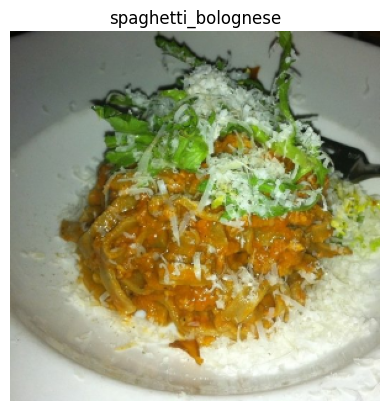

In [17]:
# We can still plot our preprocessed image as long as we
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

## Batch & prepare datasets

Before we can model our data, we have to turn it into batches.

Why?

Because computing on batches is memory efficient.

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from the [`tf.data` API](https://www.tensorflow.org/api_docs/python/tf/data).

Specifically, we're going to be using:

* [`map()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) - maps a predefined function to a target dataset (e.g. `preprocess_img()` to our image tensors)
* [`shuffle()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) - randomly shuffles the elements of a target dataset up `buffer_size` (ideally, the `buffer_size` is equal to the size of the dataset, however, this may have implications on memory)
* [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) - turns elements of a target dataset into batches (size defined by parameter `batch_size`)
* [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
* Extra: [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)

Things to note:
- Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our `preprocess_img()` function)
- `shuffle()` keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
- For methods with the `num_parallel_calls` parameter available (such as `map()`), setting it to`num_parallel_calls=tf.data.AUTOTUNE` will parallelize preprocessing and significantly improve speed
- Can't use `cache()` unless your dataset can fit in memory


In [18]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [19]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.

To do each of these we'll use the following callbacks:
* [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - allows us to keep track of our model's training history so we can inspect it later (**note:** we've created this callback before have imported it from `helper_functions.py` as `create_tensorboard_callback()`)
* [`tf.keras.callbacks.ModelCheckpoint()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
  * Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [20]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

## Setup mixed precision training

In [21]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

In [22]:
mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

<Policy "mixed_float16">

## Build feature extraction model

Recall, the typical order for using transfer learning is:

1. Build a feature extraction model (replace the top few layers of a pretrained model)
2. Train for a few epochs with lower layers frozen
3. Fine-tune if necessary with multiple layers unfrozen

In [23]:
from tensorflow.keras import layers

# Create base model
input_shape = (300, 300, 3)
base_model = tf.keras.applications.EfficientNetB3(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

43941136/43941136 [==============================] - 0s 0us/step


In [24]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetb3 (Functional  (None, None, None, 1536   10783535  
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1536)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               155237    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

## Checking layer dtype policies (are we using mixed precision?)

In [25]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb3 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [26]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1b_dwconv False float32 <Polic

## Fit the feature extraction model

In [27]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20231018-150500
Epoch 1/3
2368/2368 [==============================] - 333s 128ms/step - loss: 1.5453 - accuracy: 0.6157 - val_loss: 0.9988 - val_accuracy: 0.7325
Epoch 2/3
2368/2368 [==============================] - 317s 132ms/step - loss: 1.0595 - accuracy: 0.7197 - val_loss: 0.9121 - val_accuracy: 0.7513
Epoch 3/3
2368/2368 [==============================] - 309s 129ms/step - loss: 0.9147 - accuracy: 0.7562 - val_loss: 0.8839 - val_accuracy: 0.7601


In [28]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [29]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [30]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [31]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20231018-152117
Epoch 1/100
2368/2368 [==============================] - 372s 151ms/step - loss: 0.7483 - accuracy: 0.8066 - val_loss: 0.8513 - val_accuracy: 0.7704 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 352s 147ms/step - loss: 0.7308 - accuracy: 0.8123 - val_loss: 0.8453 - val_accuracy: 0.7672 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 351s 146ms/step - loss: 0.7198 - accuracy: 0.8157 - val_loss: 0.8401 - val_accuracy: 0.7720 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 307s 128ms/step - loss: 0.7103 - accuracy: 0.8187 - val_loss: 0.8433 - val_accuracy: 0.7696 - lr: 1.0000e-04
Epoch 5/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.7013 - accuracy: 0.8211
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 307s 12

In [33]:
model_res = model.evaluate(test_data)
model_res

790/790 [==============================] - 85s 107ms/step - loss: 0.8468 - accuracy: 0.7667


[0.84676593542099, 0.7667326927185059]